In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import UpperConfidenceBoundGenerator, ExpectedImprovementGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

sys.path.append("../")
from utils import plot_model_in_2d

In [2]:
data_dir = "../../data/20230916_LCLS_Injector/"

img_files = [
    "grid_scan_SOLN_121_and_QUAD_121.csv",
    "nn_optimization_SOLN_121_and_QUAD_121_v1.csv",
    "nn_optimization_SOLN_121_and_QUAD_121_v2.csv",
]

caget_files = [
    "nn_optimization_SOLN_121_and_QUAD_121_v3_caget.csv",
    "nn_optimization_SOLN_121_and_QUAD_121_v4_caget_vanilla.csv",
    "nn_optimization_SOLN_121_and_QUAD_121_v5_caget_vanilla.csv",
]

In [3]:
img_dfs = []
for file in img_files:
    df = pd.read_csv(data_dir + file, index_col="Unnamed: 0")
    new_index = []
    for i in range(len(df.index) // 3):
        new_index += [i] * 3
    df.index = new_index
    img_dfs.append(df)
img_df = pd.concat(img_dfs)

caget_dfs = []
for file in caget_files:
    df = pd.read_csv(data_dir + file, index_col="Unnamed: 0")
    new_index = []
    for i in range(len(df.index) // 3):
        new_index += [i] * 3
    df.index = new_index
    caget_dfs.append(df)
caget_df = pd.concat(caget_dfs)

full_df = pd.concat([img_df, caget_df])

In [4]:
vocs_yaml = """
variables:
  QUAD:IN20:121:BCTRL: [-0.02098429469554406, 0.020999198106589838]
  SOLN:IN20:121:BCTRL: [0.467, 0.479]
constraints:
  bb_penalty: [LESS_THAN, 0.0]
  log10_total_intensity: [GREATER_THAN, 4.0]
objectives: {total_size: MINIMIZE}
constants: {}
observables: []
"""

vocs = VOCS.from_yaml(vocs_yaml)
print(vocs.as_yaml())

variables:
  QUAD:IN20:121:BCTRL: [-0.02098429469554406, 0.020999198106589838]
  SOLN:IN20:121:BCTRL: [0.467, 0.479]
constraints:
  bb_penalty: [LESS_THAN, 0.0]
  log10_total_intensity: [GREATER_THAN, 4.0]
objectives: {total_size: MINIMIZE}
constants: {}
observables: []



## Load NN Prior Model

In [5]:
model_path = "../lcls_cu_injector_nn_model/"

# load sim_to_nn transformers
input_sim_to_nn = torch.load(model_path + "model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_path + "model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load(model_path + "model/input_pv_to_sim.pt")
output_pv_to_sim = torch.load(model_path + "model/output_pv_to_sim.pt")

# load in- and output variable specification
input_variables, output_variables = variables_from_yaml(open(model_path + "model/pv_variables.yml"))

# replace keys in input variables
input_variables = {name.replace("BACT", "BCTRL"): ele for name, ele in input_variables.items()}

# create LUME-model
lume_model = PyTorchModel(
    model_file=model_path + "model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],
    output_transformers=[output_sim_to_nn, output_pv_to_sim],
)

# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=list(vocs.variable_names),
    output_order=lume_model.outputs[0:2],
)

# define objective model
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        # return torch.sqrt(torch.abs(sigma_x) * torch.abs(sigma_y))
        return torch.sqrt(sigma_x ** 2 + sigma_y ** 2)

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("OTRS:IN20:571:XRMS")
        idx_sigma_y = self.model.output_order.index("OTRS:IN20:571:YRMS")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)


objective_model = ObjectiveModel(lume_module)

## Load Calibrated NN Prior Models

In [6]:
calibration_path = "../calibration/"

regs, cal_models = ["low", "high"], []
for reg in regs:
    # load nn_to_cal transformers
    input_nn_to_cal = torch.load(calibration_path + f"input_nn_to_cal_{reg}_reg.pt")
    output_nn_to_cal = torch.load(calibration_path + f"output_nn_to_cal_{reg}_reg.pt")
    
    # create LUME-model
    cal_lume_model = PyTorchModel(
        model_file=model_path + "model/model.pt",
        input_variables=input_variables,
        output_variables=output_variables,
        input_transformers=[input_pv_to_sim, input_sim_to_nn, input_nn_to_cal],
        output_transformers=[output_nn_to_cal, output_sim_to_nn, output_pv_to_sim],
    )
    
    # wrap in LUMEModule
    cal_lume_module = LUMEModule(
        model=cal_lume_model,
        feature_order=list(vocs.variable_names),
        output_order=cal_lume_model.outputs[0:2],
    )
    
    cal_models.append(ObjectiveModel(cal_lume_module))

## Calculate Correlations and MAEs

In [7]:
# define calculation of correlation
def calc_corr(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    corr = torch.corrcoef(torch.stack([a.squeeze(), b.squeeze()]))
    return corr[0, 1]

In [8]:
# define calculation of MAE
def calc_mae(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    return torch.nn.functional.l1_loss(a, b)

In [9]:
metrics = pd.DataFrame(columns=[["All Data"] * 2 + ["img"] * 2 + ["caget"] * 2, ["Corr", "MAE"] * 3])
for model in [objective_model] + cal_models:
    model_metrics = []
    for df in [full_df, img_df, caget_df]:
        # drop NaNs
        df = df[lume_module.feature_order + [vocs.objective_names[0]]]
        df = df.dropna()
        
        # inputs and targets
        x = torch.from_numpy(df[lume_module.feature_order].to_numpy())
        y = torch.from_numpy(df[vocs.objective_names[0]].to_numpy())
        
        # predictions
        pred = model(x)
        
        # model metrics
        model_metrics.append("{:.2f}".format(calc_corr(pred, y).item()))
        model_metrics.append("{:.2f}".format(calc_mae(pred, y).item()))

    metrics.loc[len(metrics.index)] = model_metrics
metrics.index = ["Original Model", "Calibrated (Low Reg)", "Calibrated (High Reg)"]

In [10]:
metrics

All Data           img         caget        
                          Corr     MAE  Corr     MAE  Corr     MAE
Original Model            0.55  290.88  0.56  293.91  0.46  279.57
Calibrated (Low Reg)      0.48  443.16  0.48  446.33  0.50  431.33
Calibrated (High Reg)     0.21  240.64  0.21  241.62  0.19  237.00

## Analyze Noise Levels

In [11]:
sigmas = {}
for dfs, files in zip([img_dfs, caget_dfs], [img_files, caget_files]):
    for df, file in zip(dfs, files):
        s = []
        for i in set(df.index):
            # verify fixed candidates
            candidates = df.loc[i][vocs.variable_names].values
            if not np.all(np.isclose(candidates, candidates[0])):
                print(f"{file}, Index {i} has inconsistent candidates")
        
            # calculate standard deviation
            y = df.loc[i][vocs.objective_names[0]]
            if np.all(np.isnan(y)):
                s.append(np.nan)
            else:
                s.append(np.nanstd(y))
        sigmas[file] = s

In [12]:
noise_levels = pd.DataFrame({k: [np.nanmean(v)] for k, v in sigmas.items()})
noise_levels.index = ["Average Standard Deviation"]
noise_levels.T

Average Standard Deviation
grid_scan_SOLN_121_and_QUAD_121.csv                                   4.792583
nn_optimization_SOLN_121_and_QUAD_121_v1.csv                          3.860609
nn_optimization_SOLN_121_and_QUAD_121_v2.csv                          4.773148
nn_optimization_SOLN_121_and_QUAD_121_v3_caget.csv                    3.025568
nn_optimization_SOLN_121_and_QUAD_121_v4_caget_...                    5.787224
nn_optimization_SOLN_121_and_QUAD_121_v5_caget_...                    7.173761

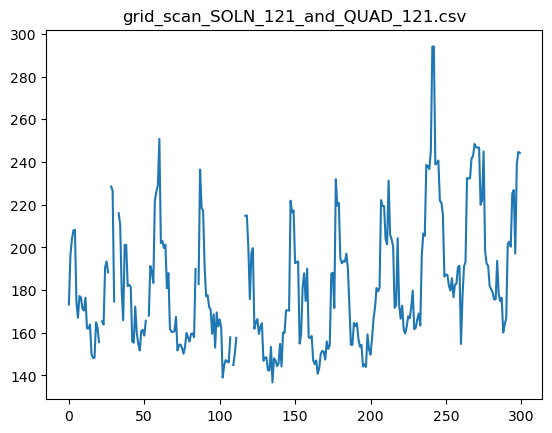

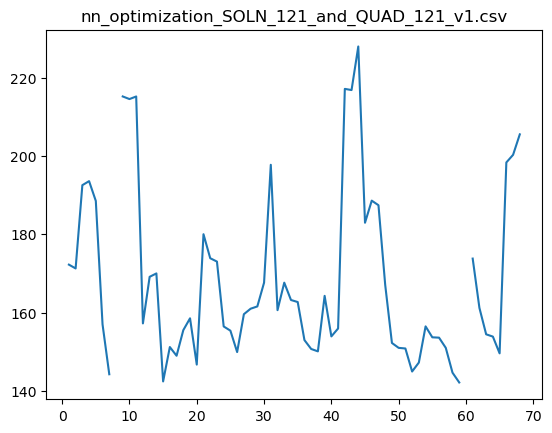

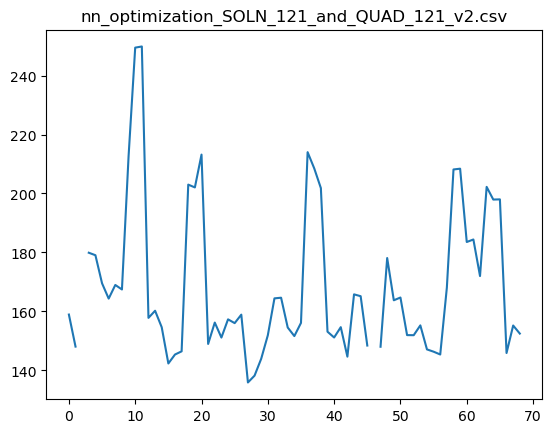

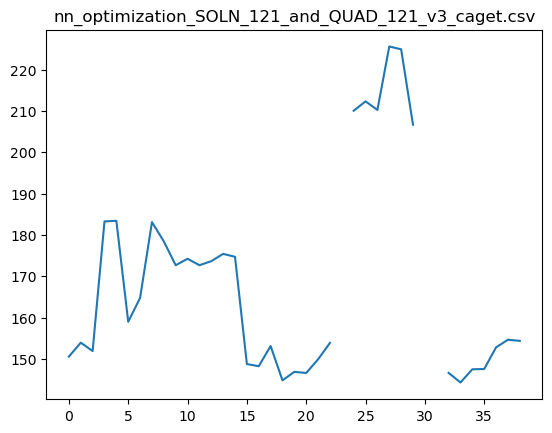

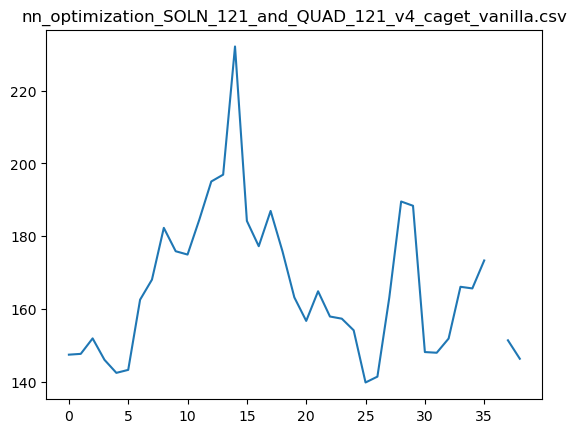

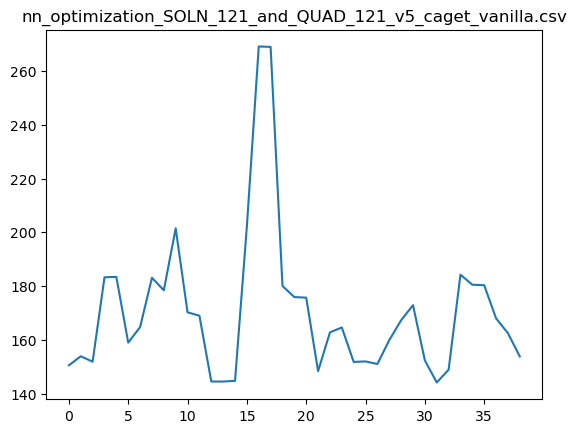

In [13]:
for df, file in zip(img_dfs + caget_dfs, img_files + caget_files):
    ax = df[vocs.objective_names[0]].plot(use_index=False)
    ax.set_title(file)
    plt.show()

## Display Models

In [14]:
# Xopt evaluator dummy function
def evaluate(input_dict):
    model_result = lume_model.evaluate(input_dict)
    sigma_xy = objective_model.function(model_result["OTRS:IN20:571:XRMS"], model_result["OTRS:IN20:571:YRMS"])
    output_dict = {vocs.objective_names[0]: sigma_xy.detach().item()}
    
    # dummy constraints
    output_dict["bb_penalty"] = -1.0  # [LESS_THAN, 0.0]
    output_dict["log10_total_intensity"] = 5.0  # [GREATER_THAN, 4.0]
    
    return output_dict

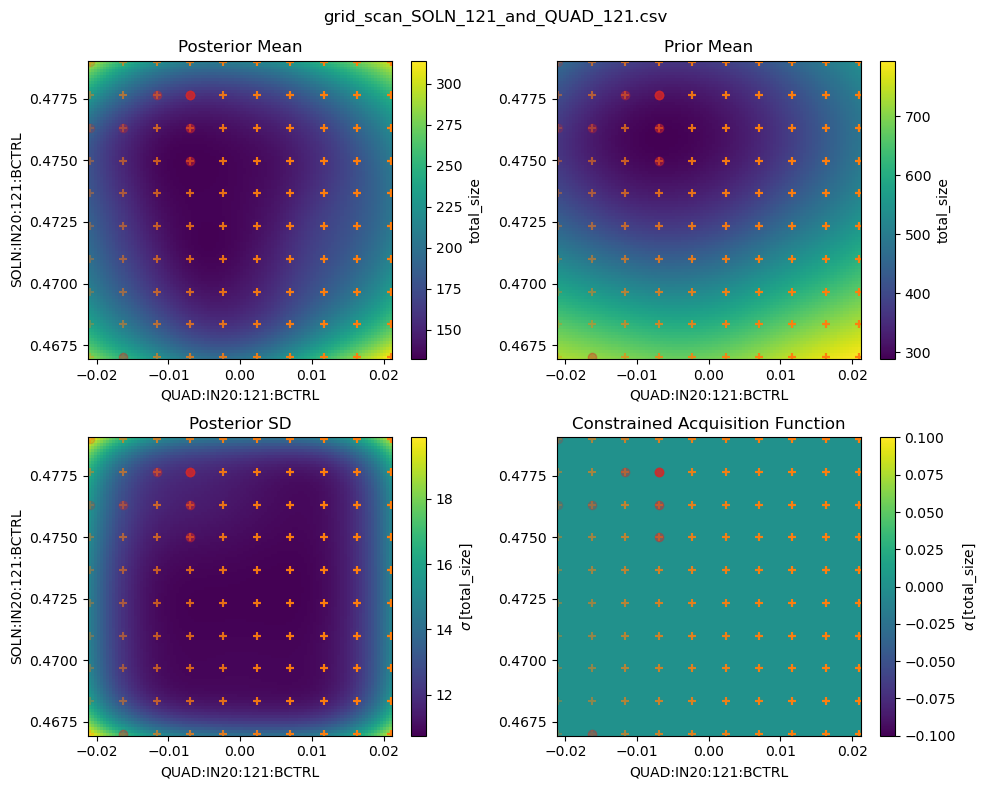

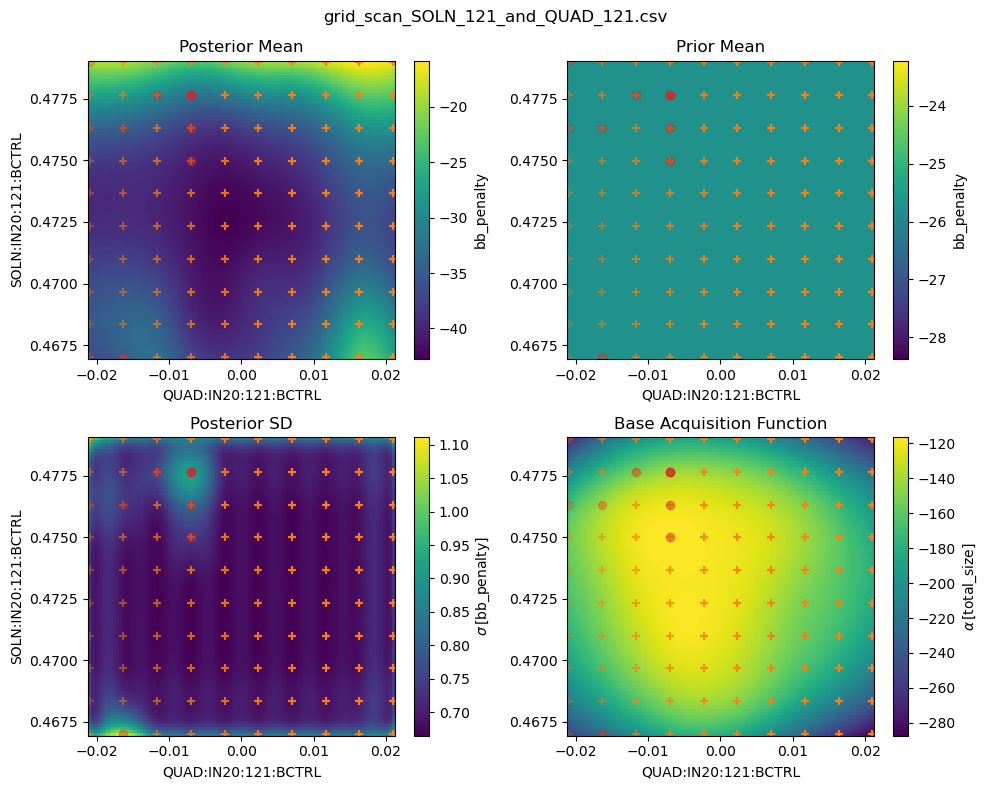

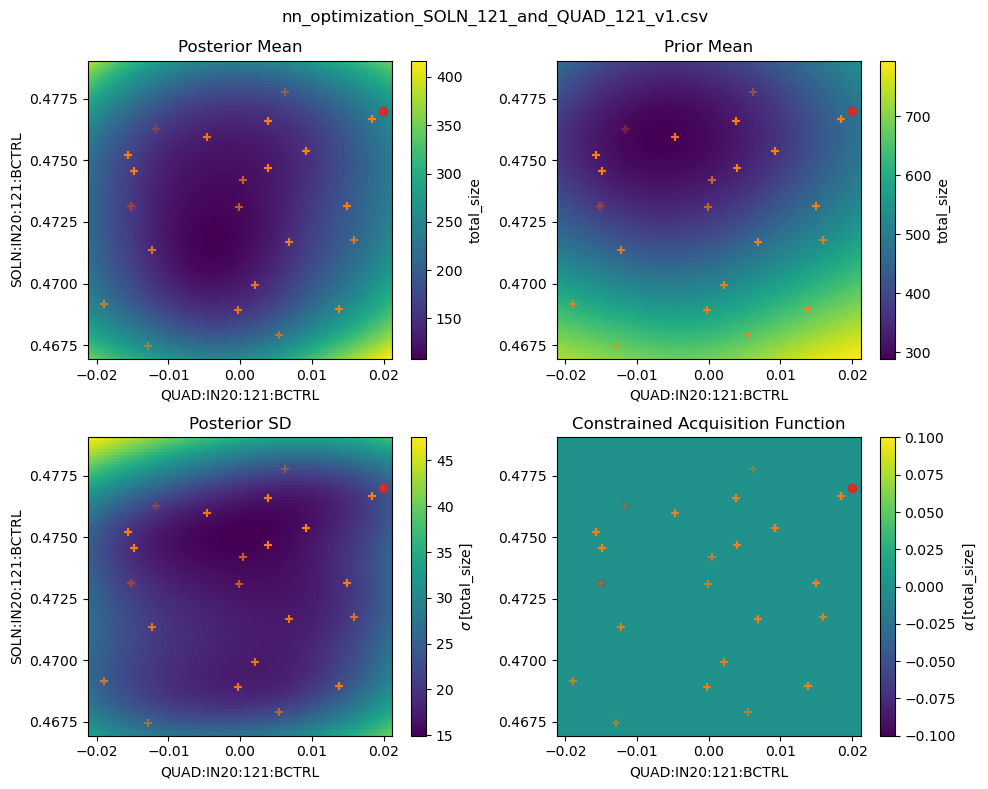

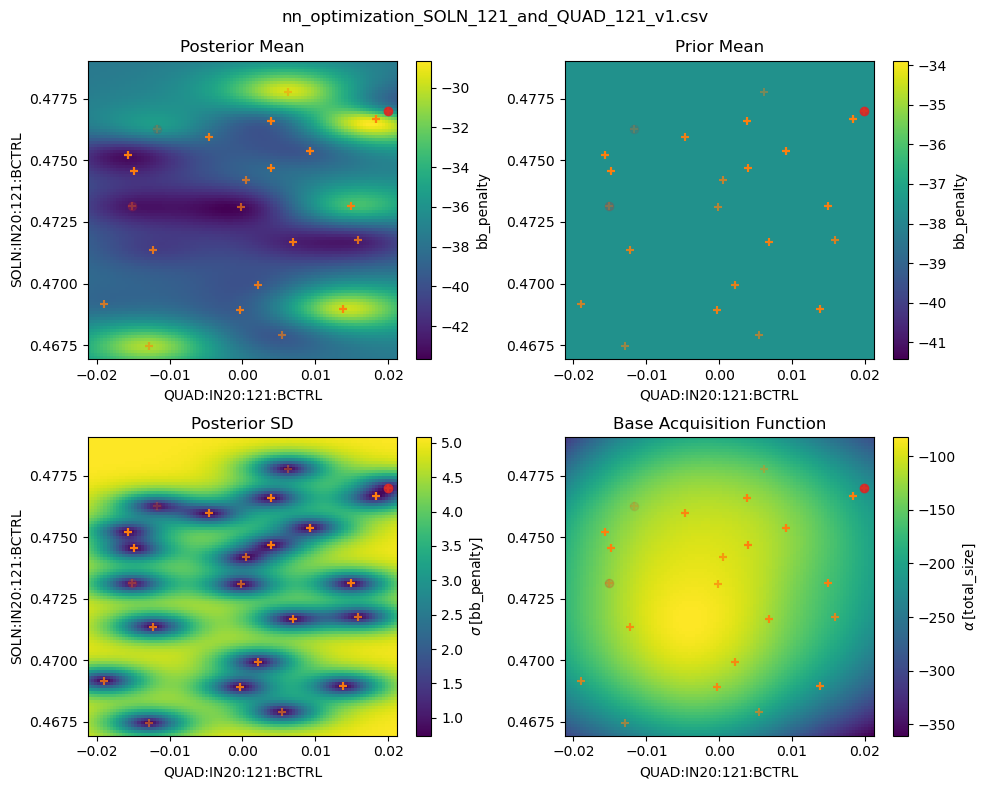

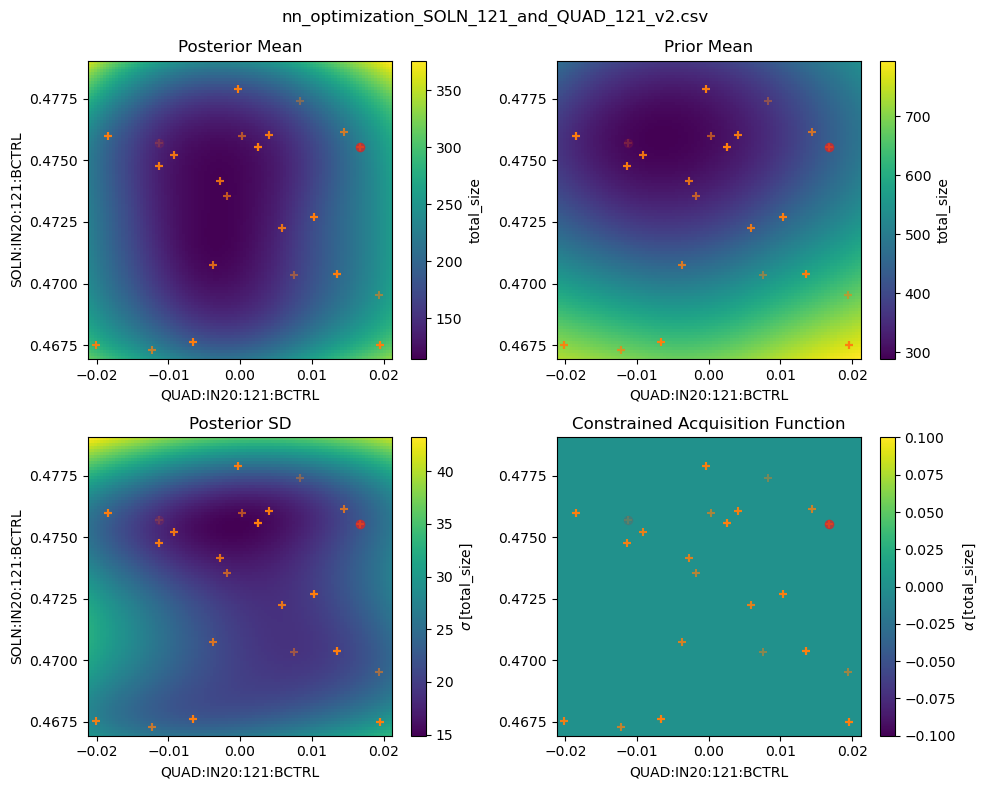

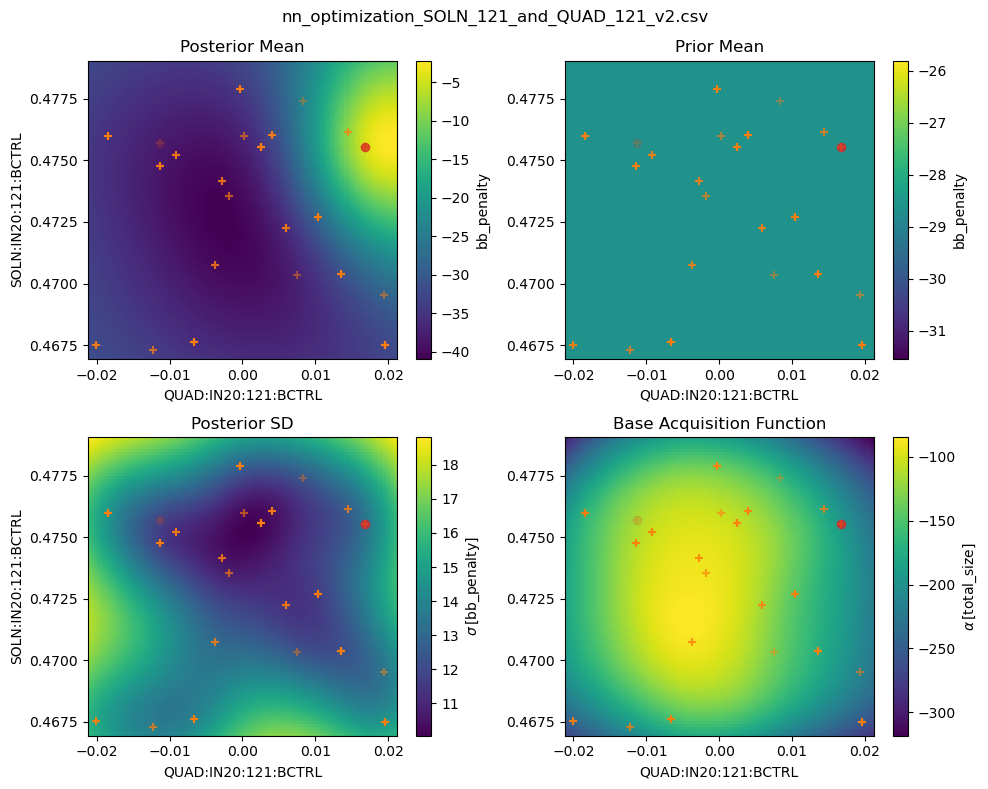

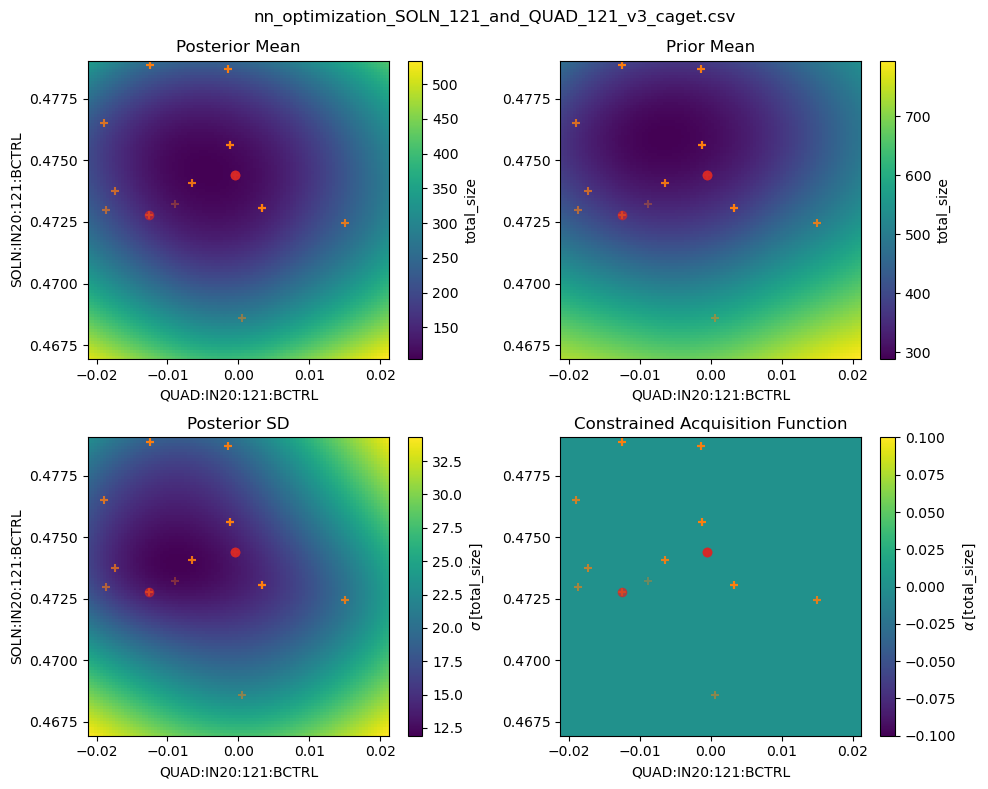

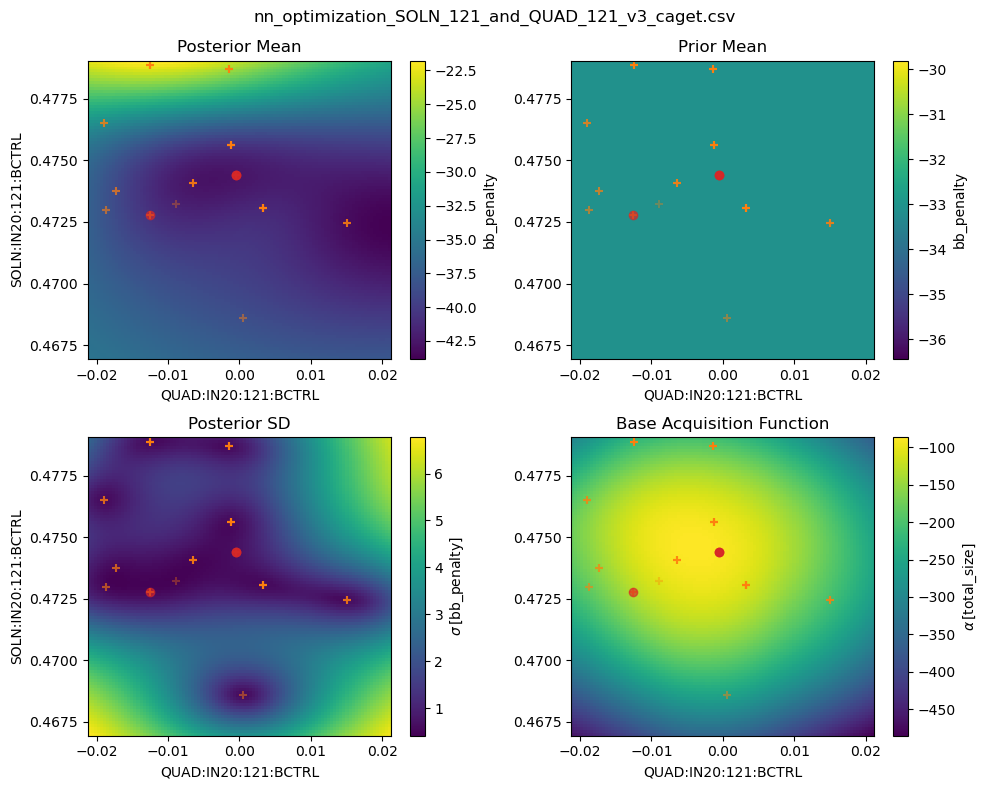

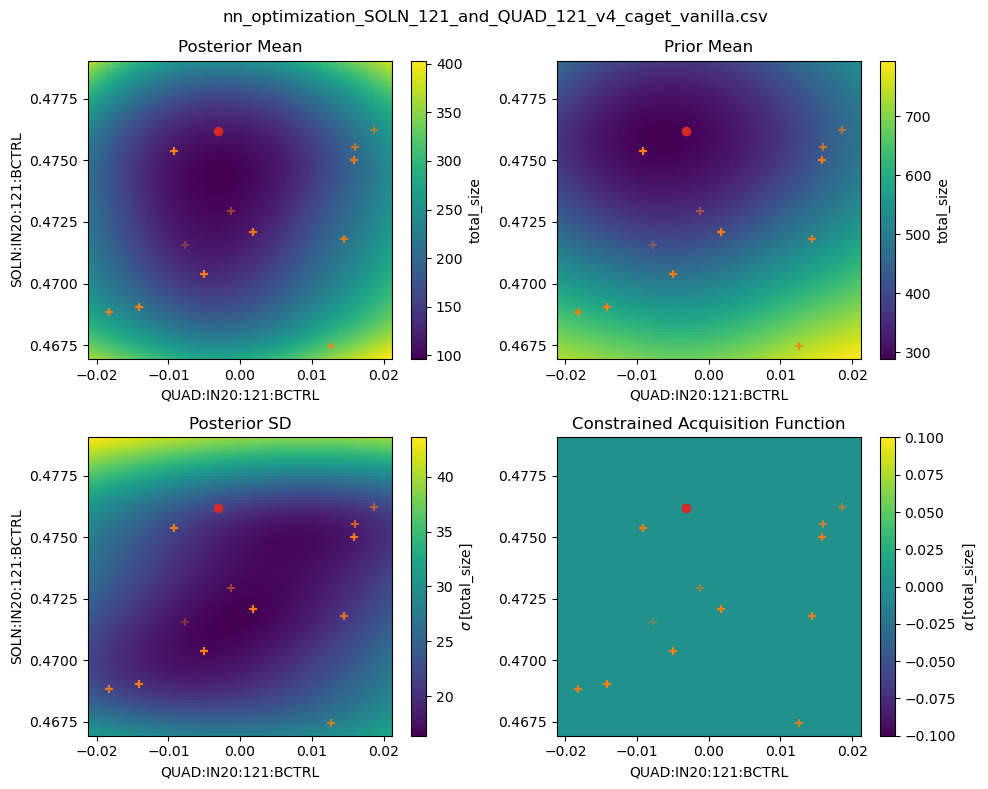

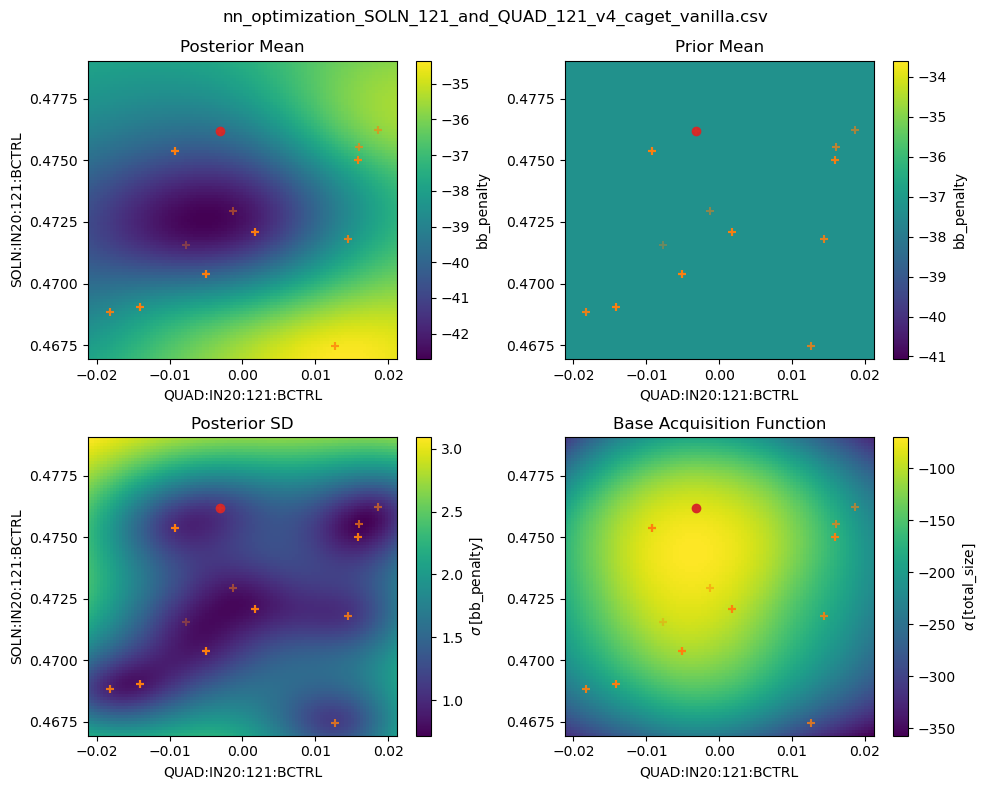

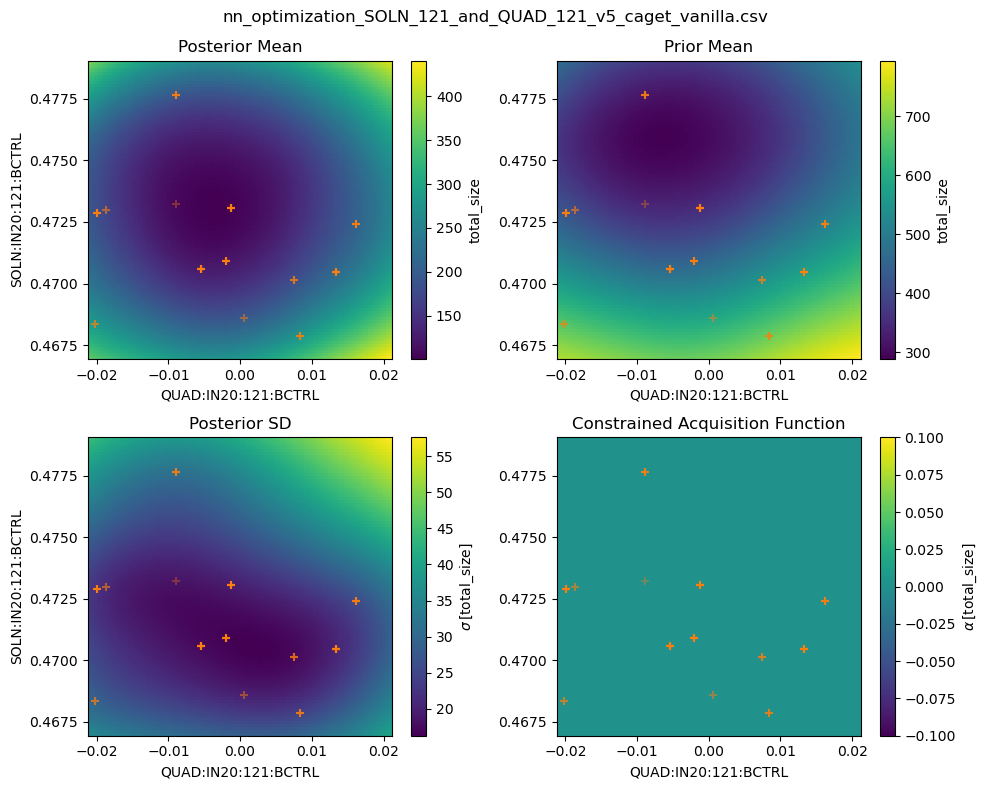

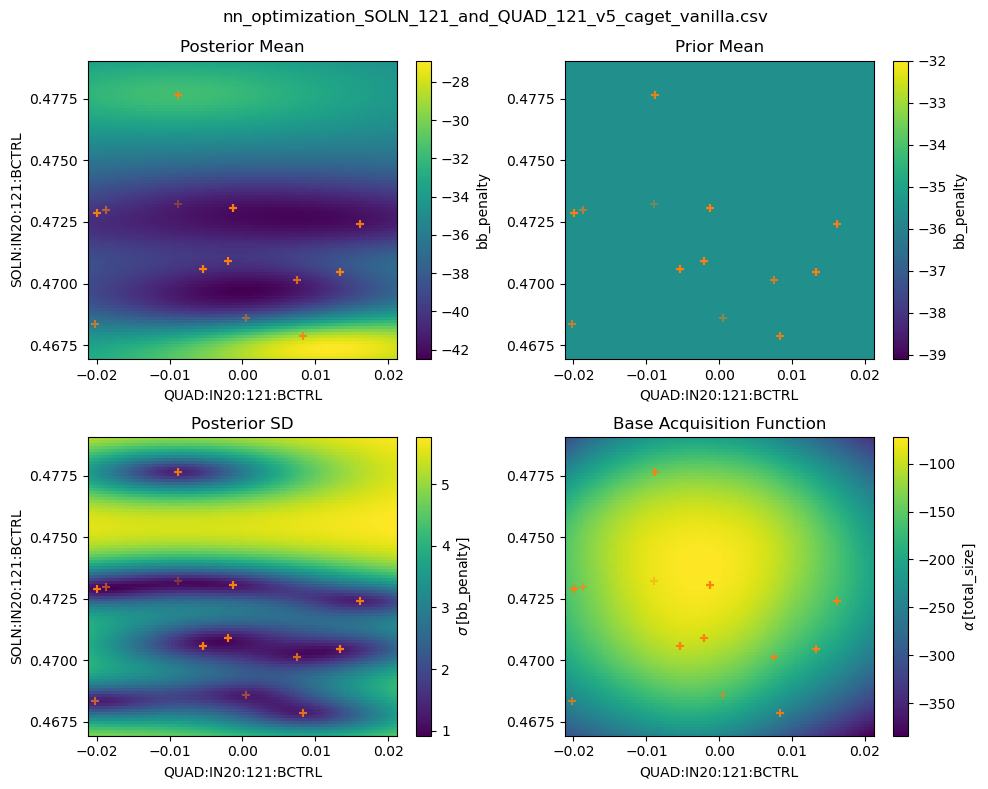

In [15]:
# Upper Confidence Bound
for df, file in zip(img_dfs + caget_dfs, img_files + caget_files):
    # build Xopt
    model_constructor = StandardModelConstructor(
        use_low_noise_prior=False,
        mean_modules={"total_size": objective_model},
    )
    generator = UpperConfidenceBoundGenerator(
        vocs=vocs,
        model_constructor=model_constructor,
    )
    generator.numerical_optimizer.max_iter = 200
    evaluator = Evaluator(function=evaluate, function_kwargs={"generator": generator})
    X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
    
    # add data and train models
    X.add_data(df)
    _ = X.generator.train_model(X.data)

    # plot objective model and constrained acquisition function
    n_grid = 100
    fig1, ax1 = plot_model_in_2d(
        X=X,
        output_name="total_size",
        variable_names=None,  # provides option to view 2D slices at higher dimensions
        constrained_acqf=True,  # display the constrained or basic acquisition function
        n_grid=n_grid,  # number of grid points per dimension
        figsize=(10,8),
        show_samples=True,
        fading_samples=True,  # older samples are more transparent
    )
    fig1.suptitle(file)
    fig1.tight_layout()

    fig2, ax2 = plot_model_in_2d(
        X=X,
        output_name="bb_penalty",  # should also work for constraints
        variable_names=None,  # provides option to view 2D slices at higher dimensions
        constrained_acqf=False,  # display the constrained or basic acquisition function
        n_grid=n_grid,  # number of grid points per dimension
        figsize=(10,8),
        show_samples=True,
        fading_samples=True,  # older samples are more transparent
    )
    fig2.suptitle(file)
    fig2.tight_layout()

    plt.show()

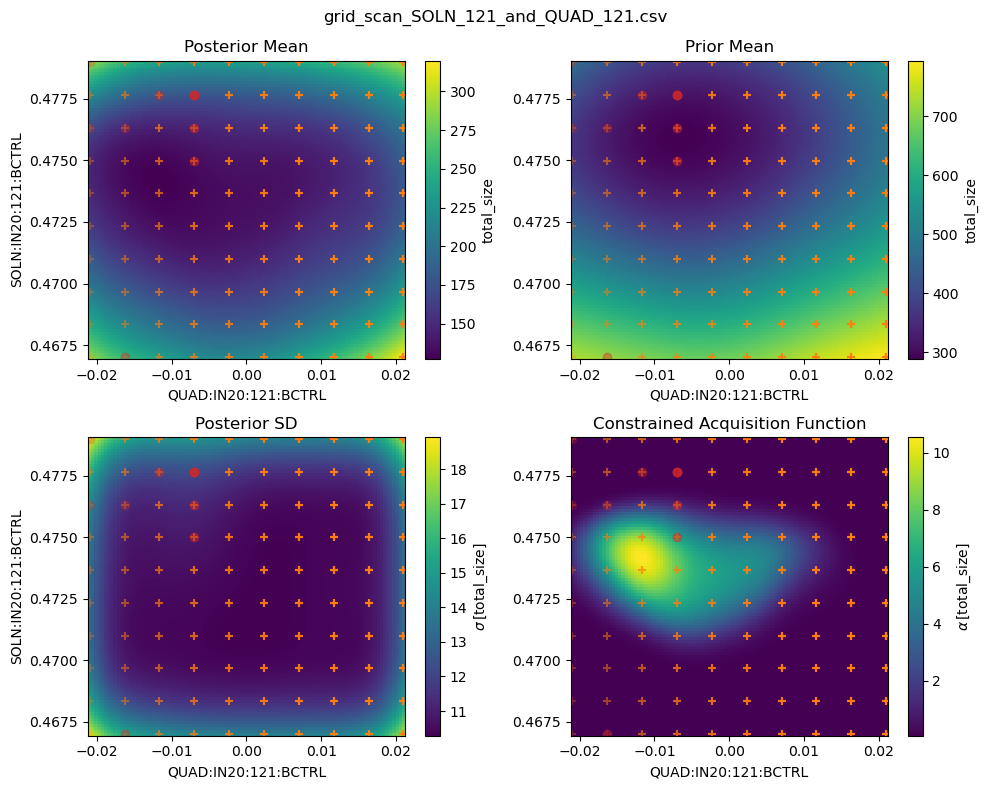

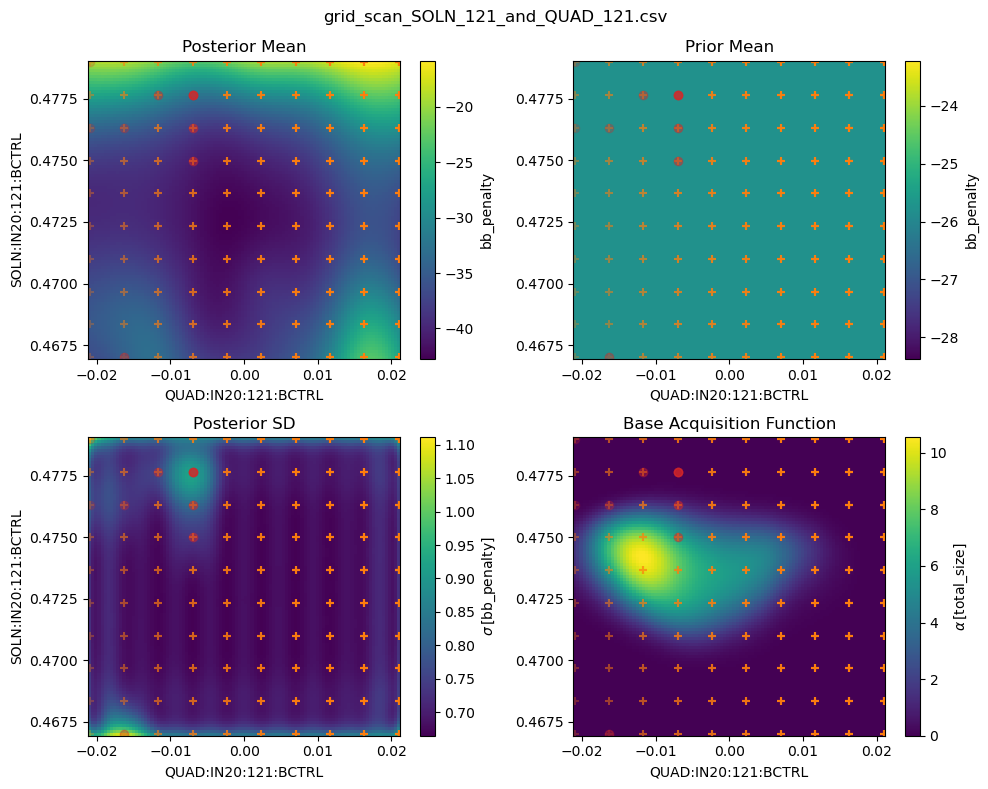

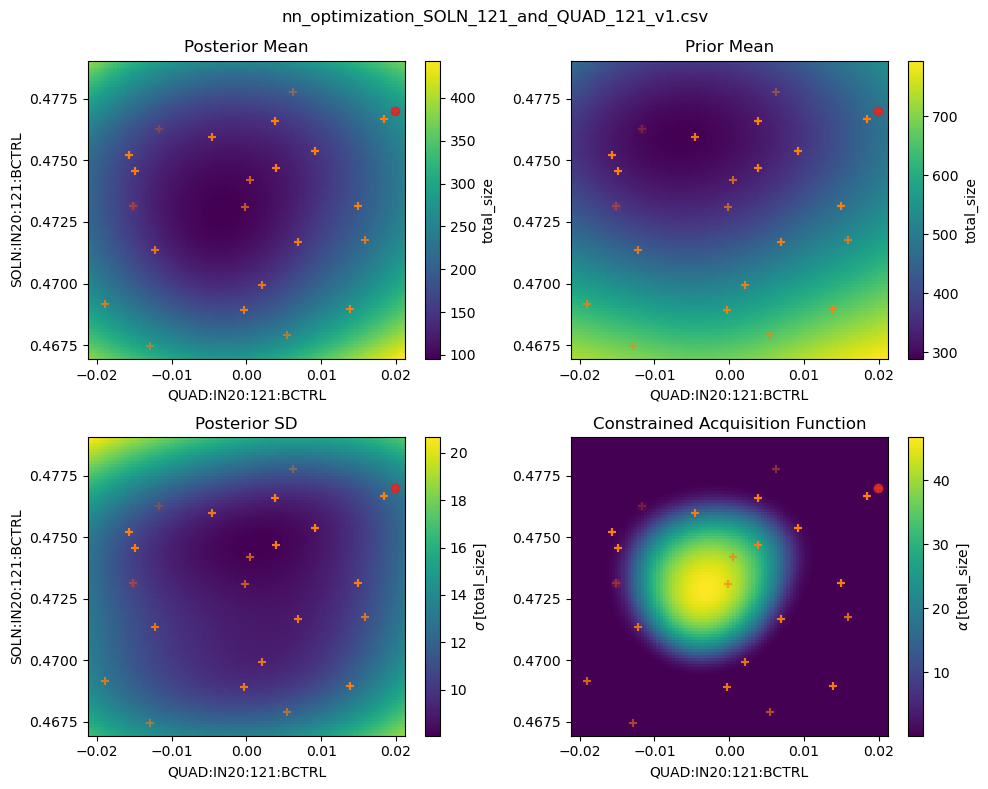

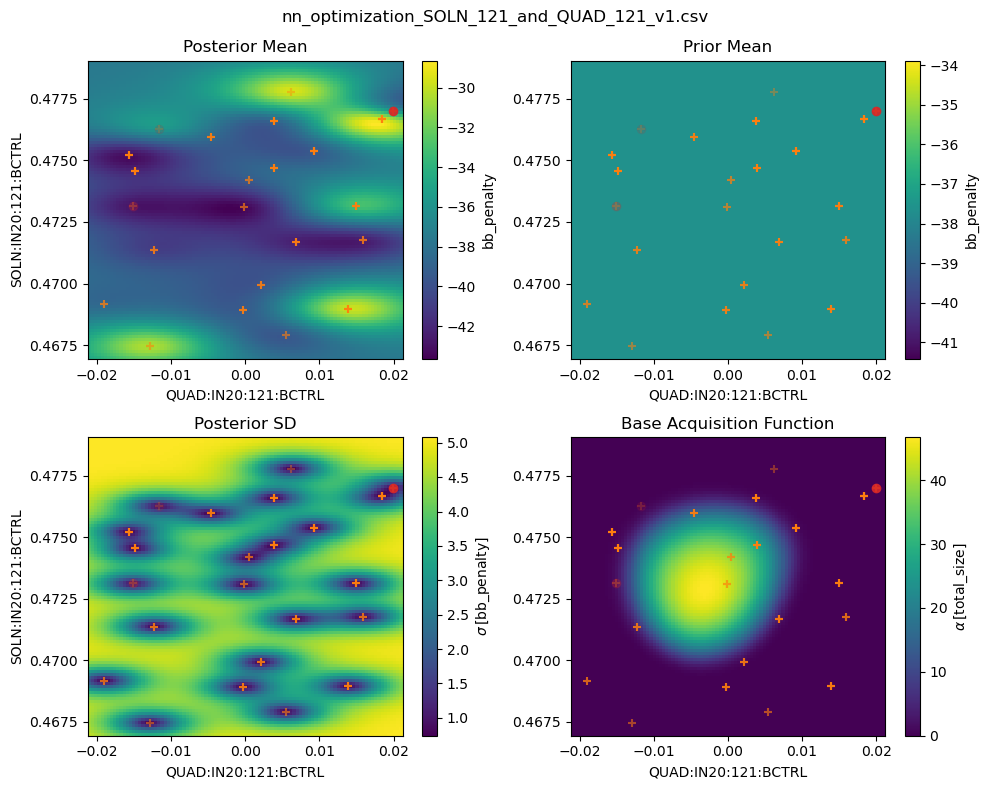

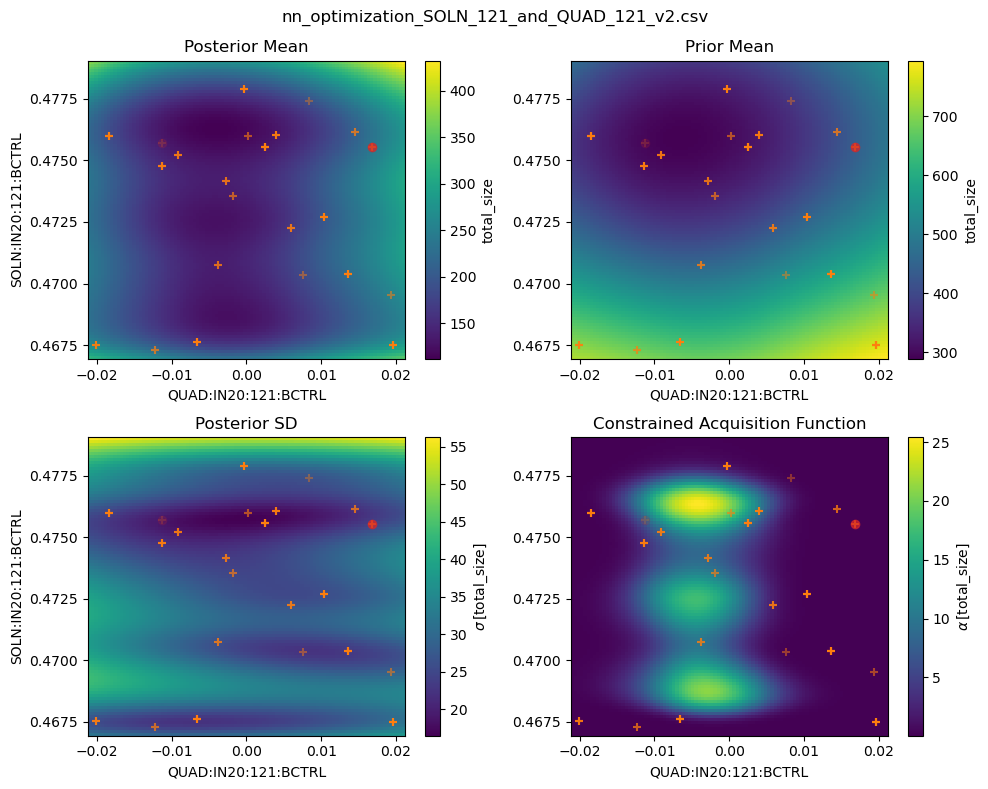

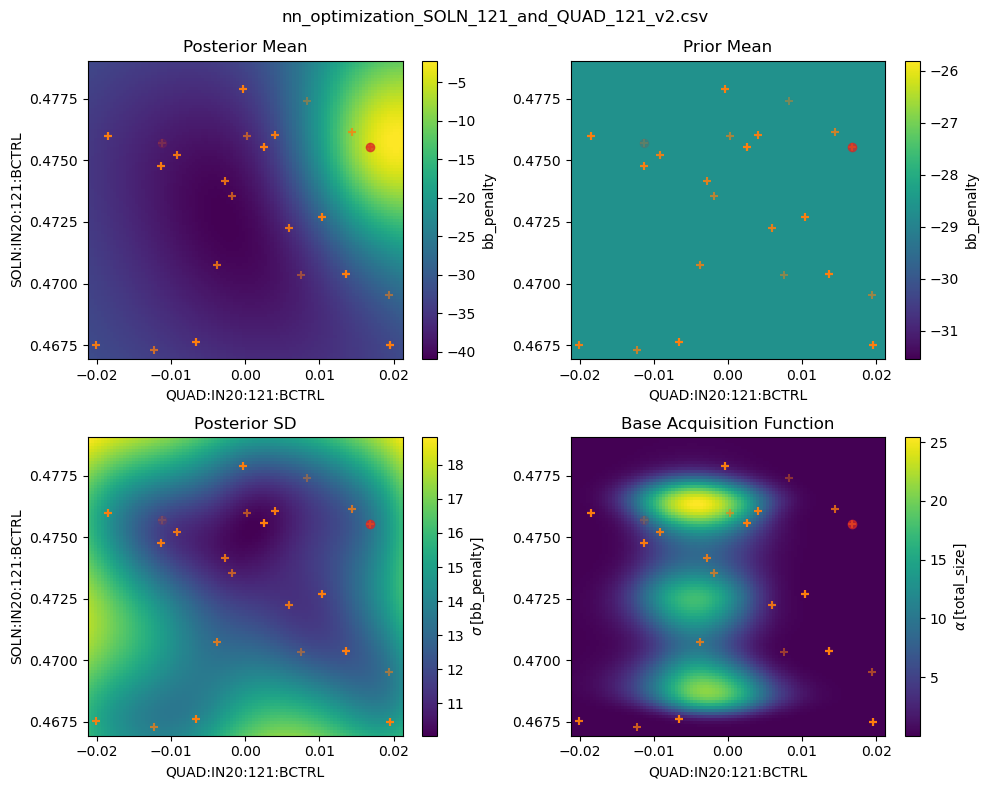

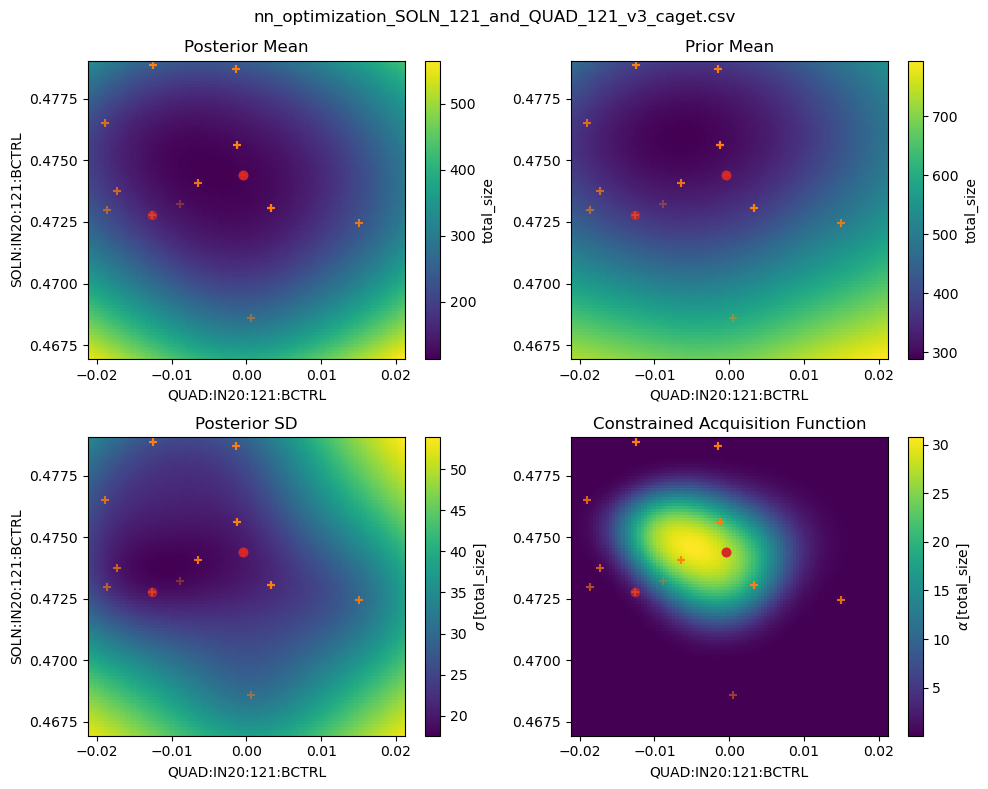

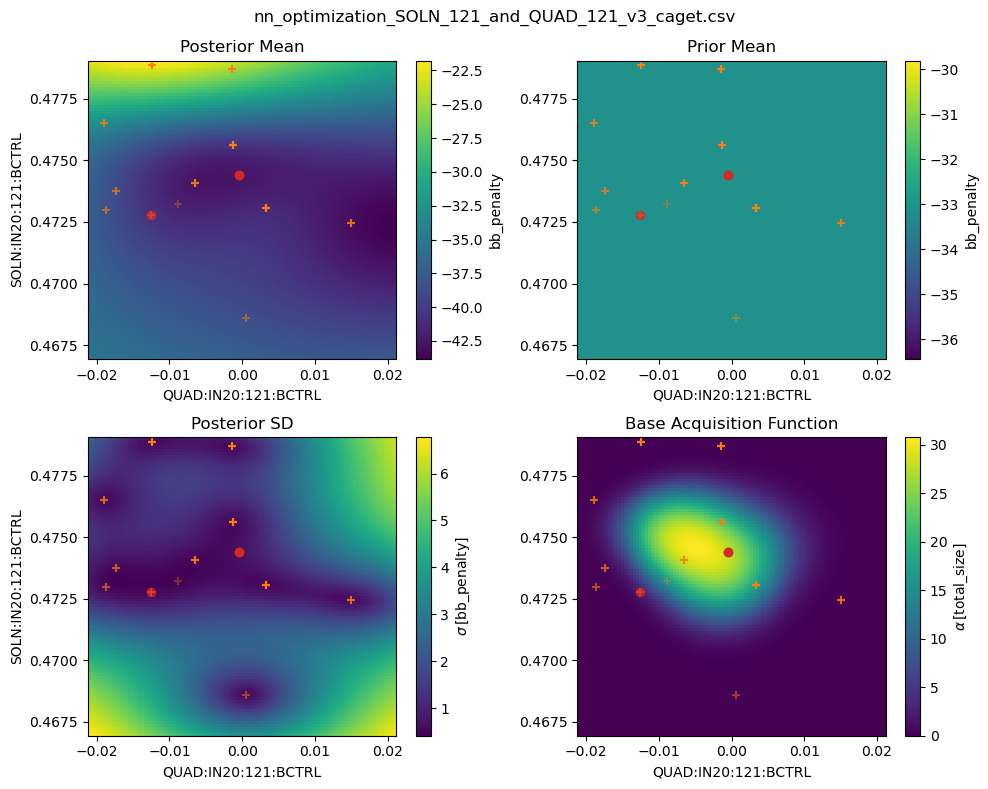

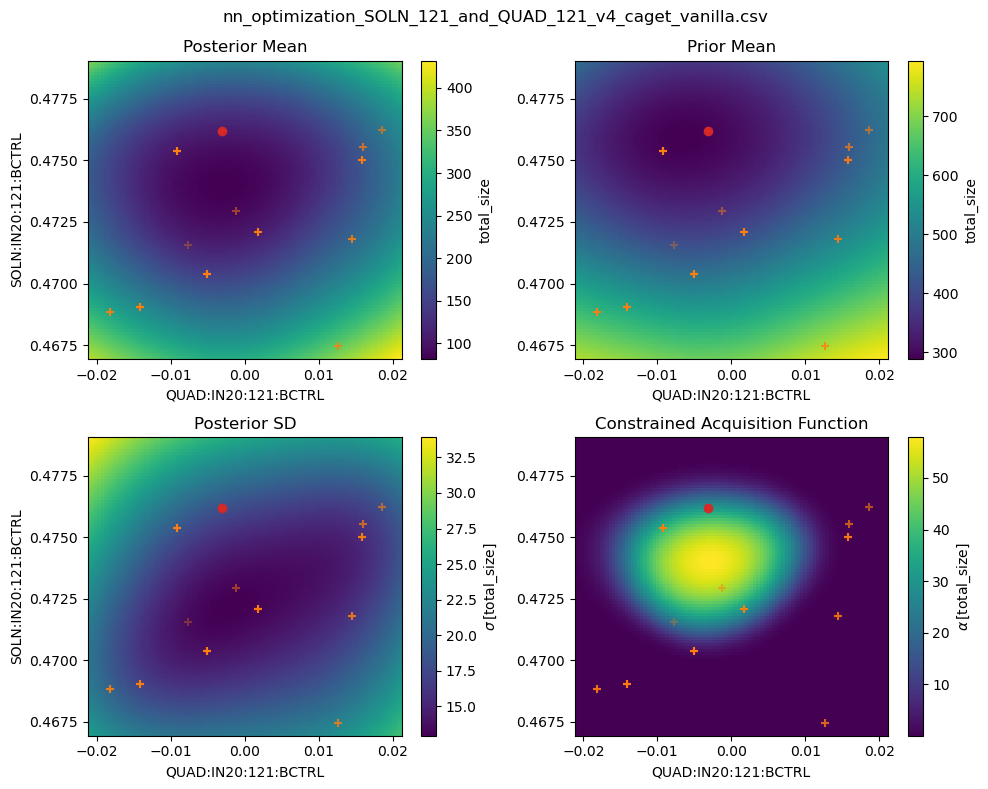

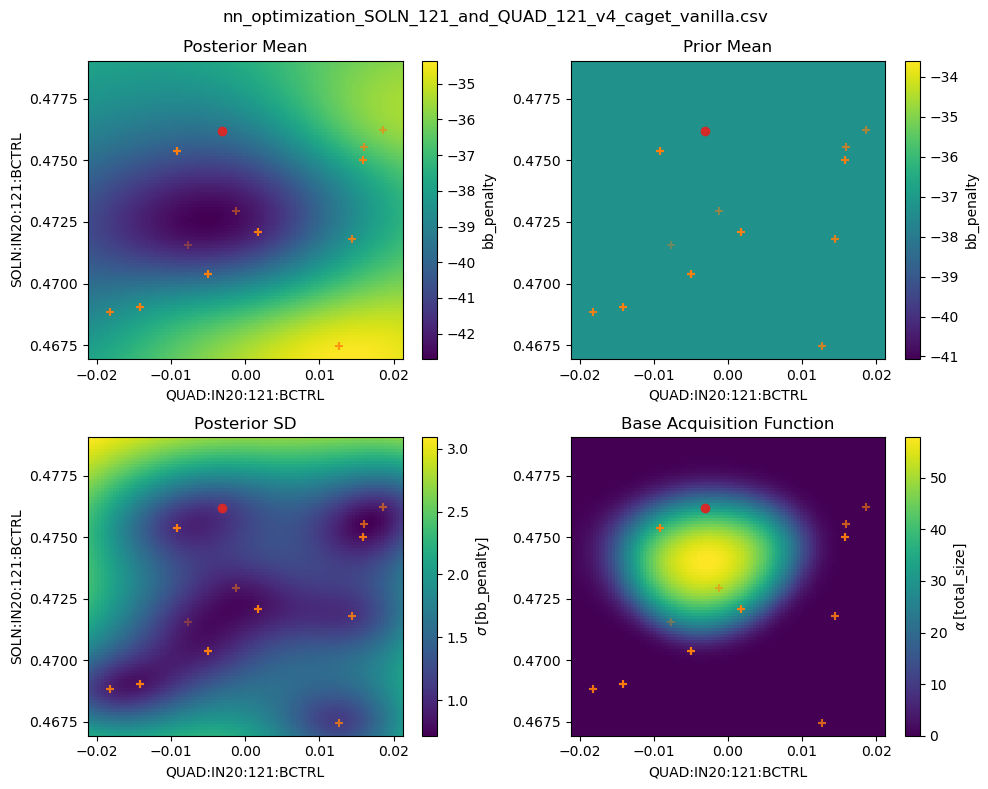

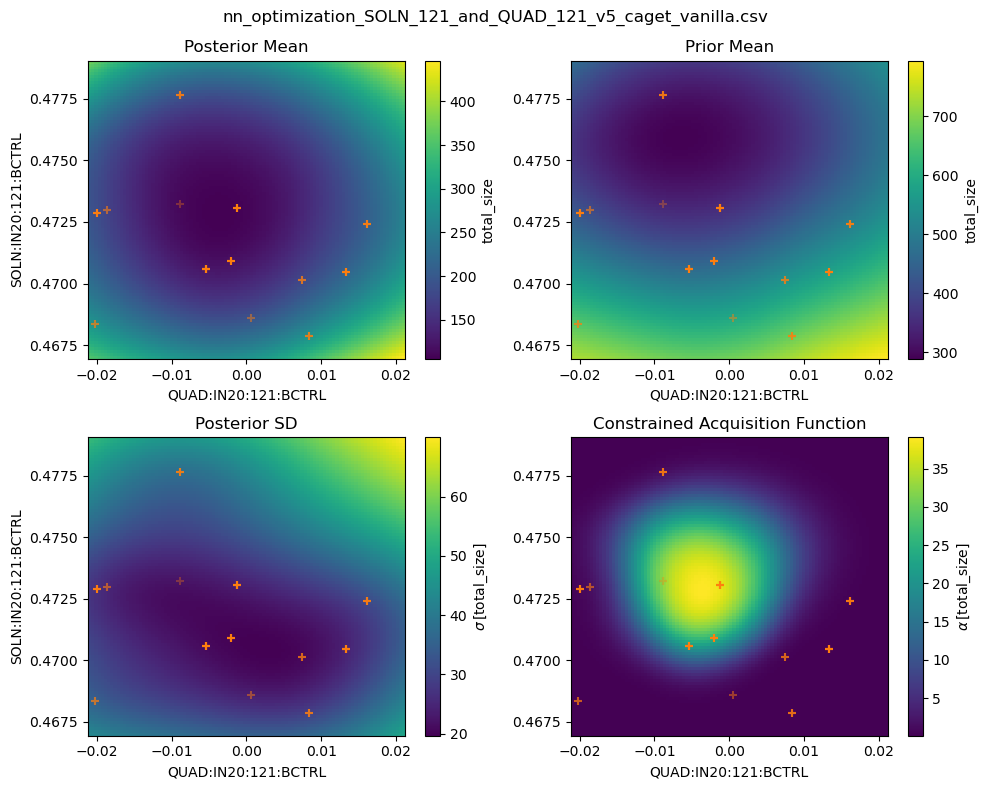

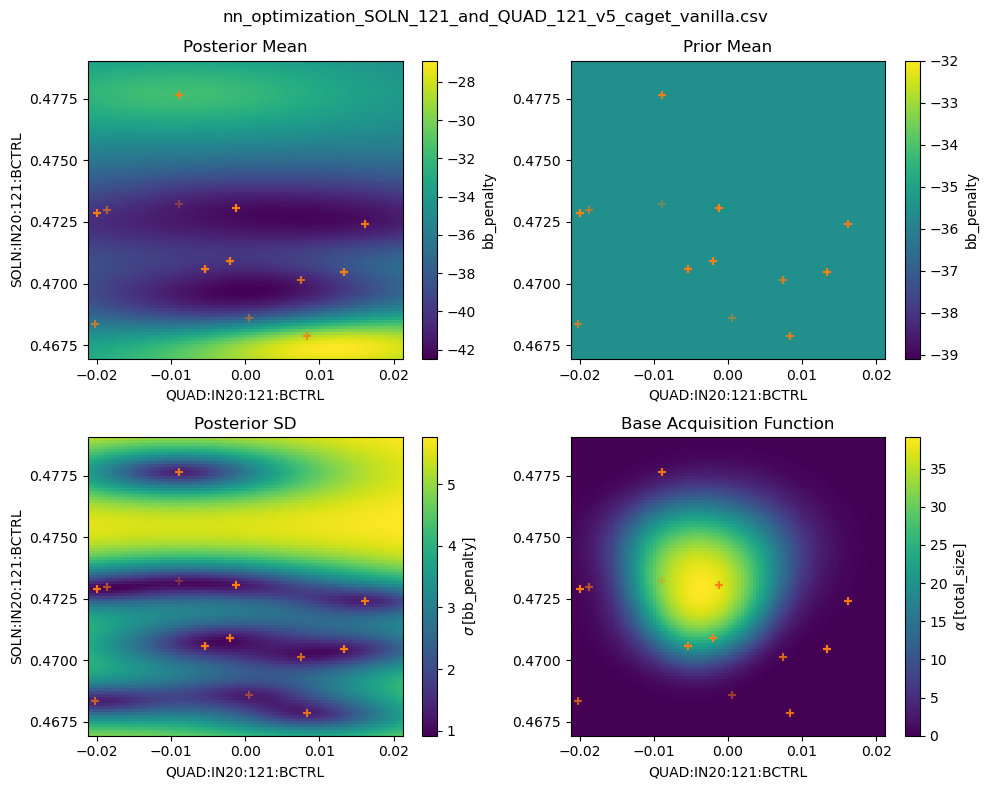

In [16]:
# Expected Improvement
for df, file in zip(img_dfs + caget_dfs, img_files + caget_files):
    # build Xopt
    model_constructor = StandardModelConstructor(
        use_low_noise_prior=False,
        mean_modules={"total_size": objective_model},
    )
    generator = ExpectedImprovementGenerator(
        vocs=vocs,
        model_constructor=model_constructor,
    )
    generator.numerical_optimizer.max_iter = 200
    evaluator = Evaluator(function=evaluate, function_kwargs={"generator": generator})
    X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
    
    # add data and train models
    X.add_data(df)
    _ = X.generator.train_model(X.data)

    # plot objective model and constrained acquisition function
    n_grid = 100
    fig1, ax1 = plot_model_in_2d(
        X=X,
        output_name="total_size",
        variable_names=None,  # provides option to view 2D slices at higher dimensions
        constrained_acqf=True,  # display the constrained or basic acquisition function
        n_grid=n_grid,  # number of grid points per dimension
        figsize=(10,8),
        show_samples=True,
        fading_samples=True,  # older samples are more transparent
    )
    fig1.suptitle(file)
    fig1.tight_layout()

    fig2, ax2 = plot_model_in_2d(
        X=X,
        output_name="bb_penalty",  # should also work for constraints
        variable_names=None,  # provides option to view 2D slices at higher dimensions
        constrained_acqf=False,  # display the constrained or basic acquisition function
        n_grid=n_grid,  # number of grid points per dimension
        figsize=(10,8),
        show_samples=True,
        fading_samples=True,  # older samples are more transparent
    )
    fig2.suptitle(file)
    fig2.tight_layout()

    plt.show()